In [1]:
import os, json, re
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed,
)

os.makedirs("figures", exist_ok=True)
set_seed(42)


In [2]:
from google.colab import files
uploaded = files.upload()
csv_name = next(iter(uploaded))
df_raw = pd.read_csv(csv_name)
df_raw.head()

Saving SEntFiN.csv to SEntFiN.csv


,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [3]:
def parse_decisions(x):
    if pd.isna(x):
        return {}
    if isinstance(x, dict):
        return x
    s = str(x).strip()
    try:
        return json.loads(s)
    except Exception:
        try:
            return json.loads(s.replace("'", '"'))
        except Exception:
            return {}
def norm_sent(lbl):
    lbl = str(lbl).strip().lower()
    if lbl in ["positive","pos","bullish","up","buy"]:
        return "positive"
    if lbl in ["negative","neg","bearish","down","sell"]:
        return "negative"
    return "neutral"

rows = []
for _, r in df_raw.iterrows():
    title = str(r.get("Title", "")).strip()
    dec = parse_decisions(r.get("Decisions", None))
    if not title or not dec:
        continue
    for ent, sent in dec.items():
        rows.append({
            "text": title,
            "entity": str(ent).strip(),
            "label_str": norm_sent(sent),
        })

df = pd.DataFrame(rows)
print("Rows:", len(df))
df["label_str"].value_counts()


Rows: 14409


,count
label_str,
neutral,5515
positive,5075
negative,3819


In [4]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v:k for k,v in label2id.items()}
df["label"] = df["label_str"].map(label2id).astype(int)
df.head()


,text,entity,label_str,label
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,neutral,1
1,MMTC Q2 net loss at Rs 10.4 crore,MMTC,neutral,1
2,"Mid-cap funds can deliver more, stay put: Experts",Mid-cap funds,positive,2
3,Mid caps now turn into market darlings,Mid caps,positive,2
4,"Market seeing patience, if not conviction: Pra...",Market,neutral,1


In [5]:
X = df["text"].tolist()
y = df["label"].tolist()
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)
print("train/val/test:", len(X_train), len(X_val), len(X_test))


train/val/test: 11527 1441 1441


In [6]:
MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_batch(texts):
    return tokenizer(texts, truncation=True,max_length=128,
    )
train_enc = tokenize_batch(X_train)
val_enc   = tokenize_batch(X_val)
test_enc  = tokenize_batch(X_test)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = SimpleDataset(train_enc, y_train)
val_ds   = SimpleDataset(val_enc, y_val)
test_ds  = SimpleDataset(test_enc, y_test)


In [8]:
# !pip install -U transformers accelerate

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }
args = TrainingArguments(
    output_dir="finbert_sentiment_out",

    # training
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,

    logging_steps=50,
    save_steps=500,
    save_total_limit=2,

    report_to="none",
    load_best_model_at_end=False,
)
trainer = Trainer(model=model,args=args,train_dataset=train_ds,eval_dataset=val_ds,tokenizer=tokenizer,
    data_collator=data_collator,compute_metrics=compute_metrics,
                  )

trainer.train()


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/tmp/ipython-input-708055677.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Step,Training Loss
50,1.178500
100,0.899300
150,0.849000
200,0.707000
250,0.601400
300,0.623100
350,0.567400
400,0.596500
450,0.488900
500,0.541900


TrainOutput(global_step=2163, training_loss=0.45461127937694307, metrics={'train_runtime': 317.6652, 'train_samples_per_second': 108.86, 'train_steps_per_second': 6.809, 'total_flos': 459672501999060.0, 'train_loss': 0.45461127937694307, 'epoch': 3.0})

In [9]:
# Validation metrics
val_metrics = trainer.evaluate(val_ds)
print("VAL:", val_metrics)

# Test predictions
pred = trainer.predict(test_ds)
test_logits = pred.predictions
test_labels = pred.label_ids
test_preds = np.argmax(test_logits, axis=-1)

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds, average="macro")

print("TEST accuracy:", test_acc)
print("TEST macro_f1:", test_f1)
print("\nConfusion matrix:\n", confusion_matrix(test_labels, test_preds))
print("\nClassification report:\n", classification_report(
    test_labels, test_preds, target_names=[id2label[i] for i in range(3)]
))

results = pd.DataFrame([
    {"model":"finbert", "split":"val",  "accuracy": float(val_metrics["eval_accuracy"]), "macro_f1": float(val_metrics["eval_macro_f1"])},
    {"model":"finbert", "split":"test", "accuracy": float(test_acc), "macro_f1": float(test_f1)},
])
results.to_csv("finbert_sentiment_results.csv", index=False)
results


VAL: {'eval_loss': 0.5536922812461853, 'eval_accuracy': 0.7841776544066621, 'eval_macro_f1': 0.7853352153412763, 'eval_runtime': 2.6224, 'eval_samples_per_second': 549.491, 'eval_steps_per_second': 17.541, 'epoch': 3.0}
TEST accuracy: 0.8049965301873698
TEST macro_f1: 0.806732740188167

Confusion matrix:
 [[331  38  13]
 [ 56 421  75]
 [ 35  64 408]]

Classification report:
               precision    recall  f1-score   support

    negative       0.78      0.87      0.82       382
     neutral       0.80      0.76      0.78       552
    positive       0.82      0.80      0.81       507

    accuracy                           0.80      1441
   macro avg       0.80      0.81      0.81      1441
weighted avg       0.81      0.80      0.80      1441



,model,split,accuracy,macro_f1
0,finbert,val,0.784178,0.785335
1,finbert,test,0.804997,0.806733


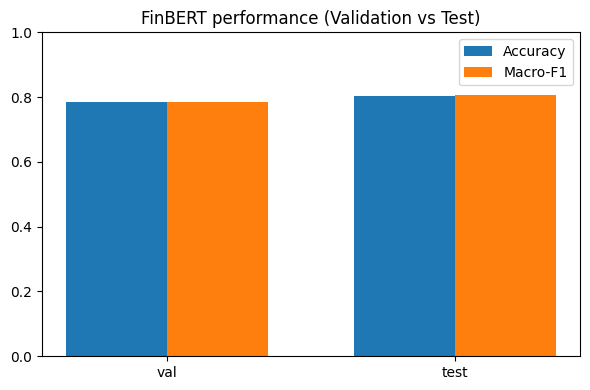

In [10]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["val", "test"]
accs = [float(val_metrics["eval_accuracy"]), float(test_acc)]
f1s  = [float(val_metrics["eval_macro_f1"]), float(test_f1)]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, accs, width, label="Accuracy")
plt.bar(x + width/2, f1s,  width, label="Macro-F1")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("FinBERT performance (Validation vs Test)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/finbert_val_test_metrics.png", dpi=200)
plt.show()


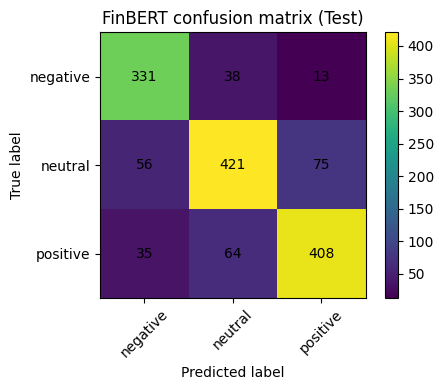

In [11]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("FinBERT confusion matrix (Test)")
plt.colorbar()

tick_marks = np.arange(3)
plt.xticks(tick_marks, [id2label[i] for i in range(3)], rotation=45)
plt.yticks(tick_marks, [id2label[i] for i in range(3)])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("figures/finbert_confusion_matrix.png", dpi=200)
plt.show()


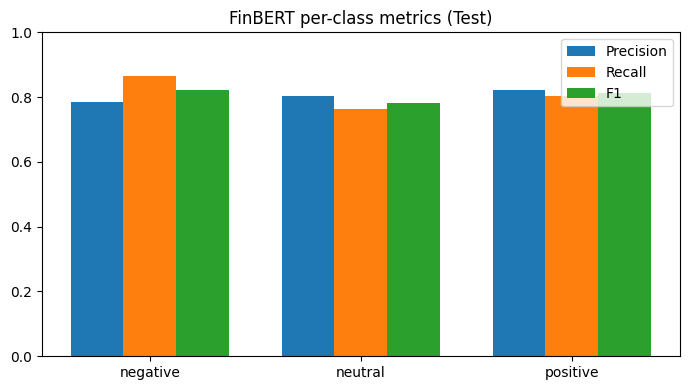

In [12]:
rep = classification_report(
    test_labels, test_preds, target_names=[id2label[i] for i in range(3)],
    output_dict=True
)

classes = ["negative", "neutral", "positive"]
precision = [rep[c]["precision"] for c in classes]
recall    = [rep[c]["recall"] for c in classes]
f1        = [rep[c]["f1-score"] for c in classes]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(7,4))
plt.bar(x - width, precision, width, label="Precision")
plt.bar(x,         recall,    width, label="Recall")
plt.bar(x + width, f1,        width, label="F1")
plt.xticks(x, classes)
plt.ylim(0, 1)
plt.title("FinBERT per-class metrics (Test)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/finbert_per_class_metrics.png", dpi=200)
plt.show()


In [13]:
trainer.save_model("finbert_sentiment_model")
tokenizer.save_pretrained("finbert_sentiment_model")
print("Saved to finbert_sentiment_model/")


Saved to finbert_sentiment_model/


## **Error Analysis**

In [14]:
import pandas as pd
import numpy as np

err_df = pd.DataFrame({
    "text": X_test,
    "true_id": y_test,
    "pred_id": test_preds,
})
err_df["true"] = err_df["true_id"].map(id2label)
err_df["pred"] = err_df["pred_id"].map(id2label)
err_df["correct"] = (err_df["true_id"] == err_df["pred_id"])
failed = err_df[~err_df["correct"]].copy()

print("Total test examples:", len(err_df))
print("Total failed examples:", len(failed))

n = min(100, len(failed))
failed_100 = failed.sample(n=n, random_state=42).copy()
failed_100["text_len_words"] = failed_100["text"].astype(str).apply(lambda s: len(s.split()))
failed_100 = failed_100[["text", "true", "pred", "text_len_words"]]
failed_100.to_csv("finbert_failed_examples_100.csv", index=False)
print("Saved: finbert_failed_examples_100.csv")

failed_100.head(10)


Total test examples: 1441
Total failed examples: 281
Saved: finbert_failed_examples_100.csv


,text,true,pred,text_len_words
168,SKS Microfinance seen struggling short-term; s...,positive,negative,8
731,"Pre-market: Nifty seen opening lower; TCS, RIL...",neutral,negative,8
1274,"IOC, BPCL may still offer value for long term ...",neutral,positive,15
1332,Investors dump higher oil bets as prices fall:...,neutral,negative,9
489,F&O: Nifty may face resistance at 5370-5400,neutral,negative,7
59,Crompton Greaves slips over 5% as Avantha Hold...,neutral,negative,13
685,"Airtel, Idea, RCom plunge upto 6.6% as Relianc...",positive,negative,13
1020,"Pharma, cement will continue to perform: IIFL ...",neutral,positive,8
677,Rupiah rises from 16-year low; won buoyed by f...,neutral,positive,10
727,"ONGC, Oil India slip as Oil Ministry proposes ...",positive,negative,15


In [15]:
def has_pattern(s, pat):
    return bool(re.search(pat, s, flags=re.IGNORECASE))

def auto_tags(text):
    t = str(text)
    tags = {
        "has_ticker": has_pattern(t, r"\$[A-Za-z]{1,6}\b"),
        "has_percent": has_pattern(t, r"\b\d+(\.\d+)?\s*%"),
        "has_number": has_pattern(t, r"\b\d{2,}\b"),
        "has_money": has_pattern(t, r"(\$|usd|million|billion|bn|mn)\b"),
        "has_url": has_pattern(t, r"(http|www\.)"),
        "has_up_down": has_pattern(t, r"\b(up|down|rise|fell|falls|gain|drop|plunge|surge|slump)\b"),
        "has_negation": has_pattern(t, r"\b(no|not|never|n't|without|hardly)\b"),
        "has_question": "?" in t,
        "has_quotes": ('"' in t) or ("'" in t),
        "has_allcaps_word": has_pattern(t, r"\b[A-Z]{3,}\b"),
        "has_exclamation": "!" in t,
        "very_short": len(t.split()) <= 6,
        "very_long": len(t.split()) >= 25,
        "has_modal": has_pattern(t, r"\b(may|might|could|should|likely|unlikely|expected|forecast)\b"),
        "has_uncertainty": has_pattern(t, r"\b(uncertain|risk|concern|warn|fear|doubt)\b"),
    }
    return tags

tags_df = err_df["text"].apply(auto_tags).apply(pd.Series)
err_df = pd.concat([err_df, tags_df], axis=1)
err_df.head()


,text,true_id,pred_id,true,pred,correct,has_ticker,has_percent,has_number,has_money,...,has_up_down,has_negation,has_question,has_quotes,has_allcaps_word,has_exclamation,very_short,very_long,has_modal,has_uncertainty
0,JBM Auto Q1 net profit soars 60 per cent,2,2,positive,positive,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
1,"HUDCO raises Rs 2,185 crore from second tranch...",1,2,neutral,positive,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2,"JSPL shares tank over 8.5%; mcap down Rs 1,482...",0,0,negative,negative,True,False,True,True,False,...,True,False,False,False,True,False,False,False,False,False
3,"SPARC, Sun Pharma slide as USFDA rescinds appr...",0,0,negative,negative,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,"Textile, pharma the only broad stories we are ...",2,1,positive,neutral,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [19]:
errors_only = err_df[~err_df["correct"]].copy()
sample_n = min(100, len(errors_only))
sample_errors = errors_only.sample(sample_n, random_state=42).copy()
sample_errors["text_len_words"] = sample_errors["text"].astype(str).apply(lambda s: len(s.split()))
manual_cols = [
    "manual_mixed_sentiment",
    "manual_ambiguous",
    "manual_sarcasm_irony",
    "manual_entity_confusion",
    "manual_event_type",
    "manual_reason_notes",
]
for c in manual_cols:
    sample_errors[c] = ""
keep_cols = [
    "text", "true", "pred", "text_len_words",
]
auto_tag_cols = [
    "has_ticker","has_percent","has_number","has_money","has_url","has_up_down",
    "has_negation","has_modal","has_uncertainty","has_question","has_quotes",
    "has_allcaps_word","has_exclamation","very_short","very_long"
]
keep_cols += [c for c in auto_tag_cols if c in sample_errors.columns]
keep_cols += manual_cols
sample_errors = sample_errors[keep_cols]
sample_errors.to_csv("error_analysis_100.csv", index=False)
print("Saved: error_analysis_100.csv")
sample_errors.head(10)


Saved: error_analysis_100.csv


,text,true,pred,text_len_words,has_ticker,has_percent,has_number,has_money,has_url,has_up_down,...,has_allcaps_word,has_exclamation,very_short,very_long,manual_mixed_sentiment,manual_ambiguous,manual_sarcasm_irony,manual_entity_confusion,manual_event_type,manual_reason_notes
168,SKS Microfinance seen struggling short-term; s...,positive,negative,8,False,True,False,False,False,True,...,True,False,False,False,,,,,,
731,"Pre-market: Nifty seen opening lower; TCS, RIL...",neutral,negative,8,False,False,False,False,False,False,...,True,False,False,False,,,,,,
1274,"IOC, BPCL may still offer value for long term ...",neutral,positive,15,False,False,False,False,False,False,...,True,False,False,False,,,,,,
1332,Investors dump higher oil bets as prices fall:...,neutral,negative,9,False,False,False,False,False,False,...,True,False,False,False,,,,,,
489,F&O: Nifty may face resistance at 5370-5400,neutral,negative,7,False,False,True,False,False,False,...,True,False,False,False,,,,,,
59,Crompton Greaves slips over 5% as Avantha Hold...,neutral,negative,13,False,True,False,False,False,False,...,True,False,False,False,,,,,,
685,"Airtel, Idea, RCom plunge upto 6.6% as Relianc...",positive,negative,13,False,True,False,False,False,True,...,True,False,False,False,,,,,,
1020,"Pharma, cement will continue to perform: IIFL ...",neutral,positive,8,False,False,False,False,False,False,...,True,False,False,False,,,,,,
677,Rupiah rises from 16-year low; won buoyed by f...,neutral,positive,10,False,False,True,False,False,False,...,True,False,False,False,,,,,,
727,"ONGC, Oil India slip as Oil Ministry proposes ...",positive,negative,15,False,False,False,False,False,False,...,True,False,False,False,,,,,,


In [20]:
auto_tag_cols = [
    "has_ticker","has_percent","has_number","has_money","has_url","has_up_down",
    "has_negation","has_modal","has_uncertainty","has_question","has_quotes",
    "has_allcaps_word","has_exclamation","very_short","very_long"
]

def rate_table(df, name):
    rates = df[auto_tag_cols].mean().sort_values(ascending=False)
    out = pd.DataFrame({"property": rates.index, f"{name}_rate": rates.values})
    return out

tbl_err = rate_table(err_df[~err_df["correct"]], "error")
tbl_ok  = rate_table(err_df[ err_df["correct"]], "correct")

summary = tbl_err.merge(tbl_ok, on="property")
summary["delta_error_minus_correct"] = summary["error_rate"] - summary["correct_rate"]
summary = summary.sort_values("delta_error_minus_correct", ascending=False)

summary.to_csv("error_vs_correct_property_rates.csv", index=False)
summary.head(15)


,property,error_rate,correct_rate,delta_error_minus_correct
2,has_modal,0.096085,0.069828,0.026258
3,has_quotes,0.092527,0.073276,0.019251
6,has_negation,0.028470,0.012069,0.016401
10,has_uncertainty,0.007117,0.002586,0.004531
11,has_exclamation,0.003559,0.000000,0.003559
9,has_question,0.014235,0.012931,0.001304
8,has_money,0.021352,0.020690,0.000663
13,has_url,0.000000,0.000000,0.000000
12,has_ticker,0.000000,0.000000,0.000000
14,very_long,0.000000,0.000000,0.000000


In [21]:
auto_tag_cols = [
    "has_ticker","has_percent","has_number","has_money","has_url","has_up_down",
    "has_negation","has_modal","has_uncertainty","has_question","has_quotes",
    "has_allcaps_word","has_exclamation","very_short","very_long"
]

def rate_table(df, name):
    rates = df[auto_tag_cols].mean().sort_values(ascending=False)
    out = pd.DataFrame({"property": rates.index, f"{name}_rate": rates.values})
    return out

tbl_err = rate_table(err_df[~err_df["correct"]], "error")
tbl_ok  = rate_table(err_df[ err_df["correct"]], "correct")

summary = tbl_err.merge(tbl_ok, on="property")
summary["delta_error_minus_correct"] = summary["error_rate"] - summary["correct_rate"]
summary = summary.sort_values("delta_error_minus_correct", ascending=False)
summary.to_csv("error_vs_correct_property_rates.csv", index=False)
summary.head(15)


,property,error_rate,correct_rate,delta_error_minus_correct
2,has_modal,0.096085,0.069828,0.026258
3,has_quotes,0.092527,0.073276,0.019251
6,has_negation,0.028470,0.012069,0.016401
10,has_uncertainty,0.007117,0.002586,0.004531
11,has_exclamation,0.003559,0.000000,0.003559
9,has_question,0.014235,0.012931,0.001304
8,has_money,0.021352,0.020690,0.000663
13,has_url,0.000000,0.000000,0.000000
12,has_ticker,0.000000,0.000000,0.000000
14,very_long,0.000000,0.000000,0.000000


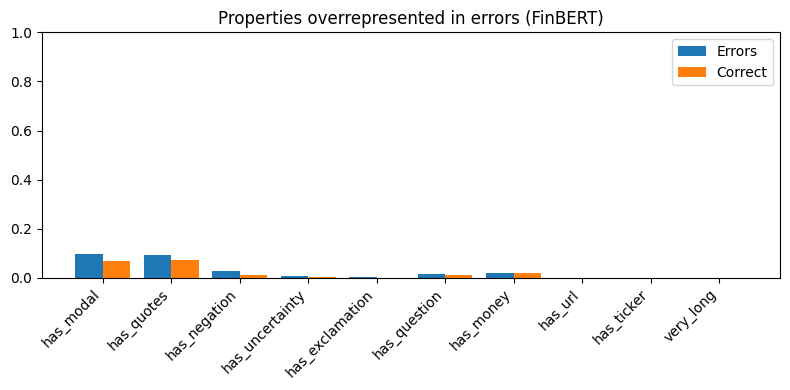

In [22]:
topk = 10
plot_df = summary.head(topk).copy()

x = np.arange(len(plot_df))
plt.figure(figsize=(8,4))
plt.bar(x - 0.2, plot_df["error_rate"], 0.4, label="Errors")
plt.bar(x + 0.2, plot_df["correct_rate"], 0.4, label="Correct")
plt.xticks(x, plot_df["property"], rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Properties overrepresented in errors (FinBERT)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/error_properties_finbert.png", dpi=200)
plt.show()


In [23]:
conf_break = (
    err_df[~err_df["correct"]]
    .groupby(["true","pred"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

conf_break.to_csv("error_confusion_pairs.csv", index=False)
conf_break.head(20)


,true,pred,count
3,neutral,positive,75
5,positive,neutral,64
2,neutral,negative,56
0,negative,neutral,38
4,positive,negative,35
1,negative,positive,13
